In [1]:
!pip install Pillow

In [3]:
!pip install seaborn


In [ ]:
'''
1. Setting Up and Loading Data 

Firstly, we need to import all the neccessary libraries and load the metadata file 
'''

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Configuration
DATA_DIR = '/Users/tejii.03/Documents/Projects/Skin Cancer Detection/Skin-Cancer-Detection/data'
METADATA_FILE = os.path.join(DATA_DIR, '/Users/tejii.03/Documents/Projects/Skin Cancer Detection/Skin-Cancer-Detection/data/HAM10000_metadata.csv')
IMAGE_FOLDER = os.path.join(DATA_DIR, '/Users/tejii.03/Documents/Projects/Skin Cancer Detection/Skin-Cancer-Detection/data/images')

# Load the metadata
df = pd.read_csv(METADATA_FILE)

print("Data Loaded. First 5 rows of metadata:")
print(df.head())
print("\nData Information:")
df.info()

Data Loaded. First 5 rows of metadata:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 5

In [ ]:
'''
1. Exploring Class Distribution
The HAM10000 dataset is highly imbalanced, which is the most critical issue you need to visualize and address '''

In [ ]:
'''
A. Diagnosis Count
Use a count plot to visualize the number of images per diagnostic class (dx). '''

/var/folders/83/h1k23b6d73q6bzjhsb_3p7440000gn/T/ipykernel_24807/386018603.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='dx', data=df, order=df['dx'].value_counts().index, palette="viridis")


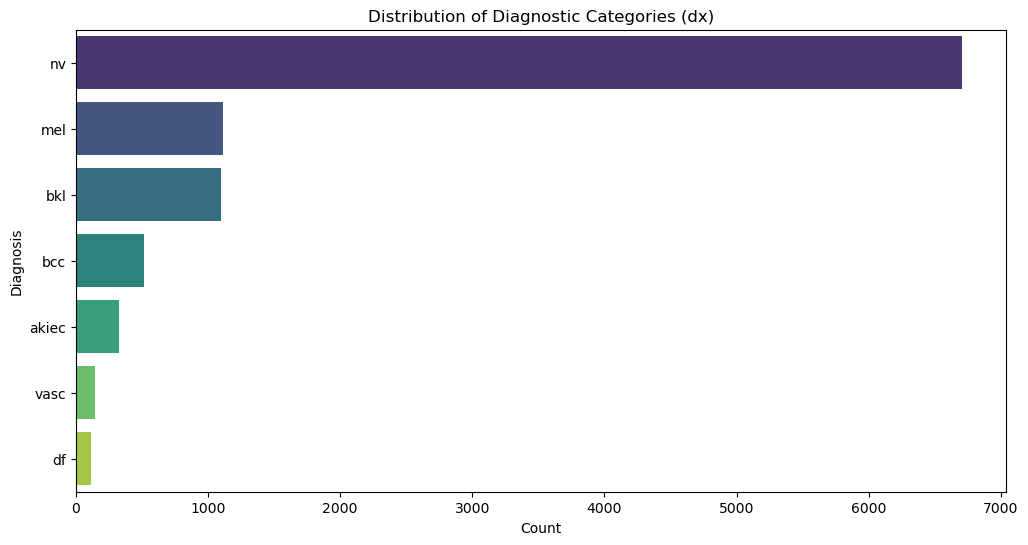


Value Counts for Diagnosis (dx):
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [8]:
## Class Distribution Plot

plt.figure(figsize=(12, 6))
sns.countplot(y='dx', data=df, order=df['dx'].value_counts().index, palette="viridis")
plt.title('Distribution of Diagnostic Categories (dx)')
plt.xlabel('Count')
plt.ylabel('Diagnosis')
plt.show()

print("\nValue Counts for Diagnosis (dx):")
print(df['dx'].value_counts())

In [ ]:
''' 
Observation: 
Here, we see a massive skew towards 'nv' (Melanocytic nevi), which typically accounts for over 60% of the dataset. 
This is why standard accuracy is a poor metric for this project.'''

In [ ]:
'''
B. Lesion Type Distribution
The dataset also provides information on the type of lesion (lesion_id). 
While many lesions are represented by a single image, some are represented by multiple.
'''


Total Images: 10015
Total Unique Lesions: 7470
Average Images per Lesion: 1.34


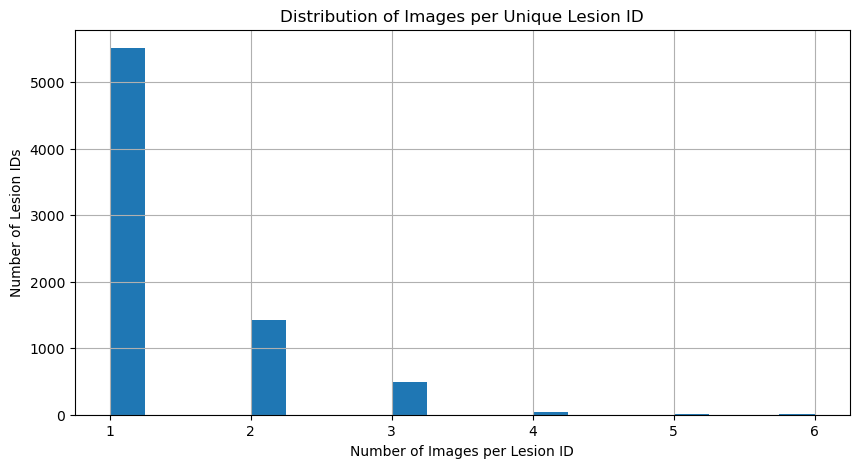

In [5]:
## Unique Lesion Count

unique_lesions = df['lesion_id'].nunique()
total_images = len(df)

print(f"\nTotal Images: {total_images}")
print(f"Total Unique Lesions: {unique_lesions}")
print(f"Average Images per Lesion: {total_images / unique_lesions:.2f}")

# Plot a histogram of how many images each lesion ID has
lesion_counts = df.groupby('lesion_id')['image_id'].count()

plt.figure(figsize=(10, 5))
lesion_counts.hist(bins=20)
plt.title('Distribution of Images per Unique Lesion ID')
plt.xlabel('Number of Images per Lesion ID')
plt.ylabel('Number of Lesion IDs')
plt.show()

In [ ]:
'''
3. Visualize Sample Images
It's helpful to see what the input images look like and confirm the colorspace.
'''

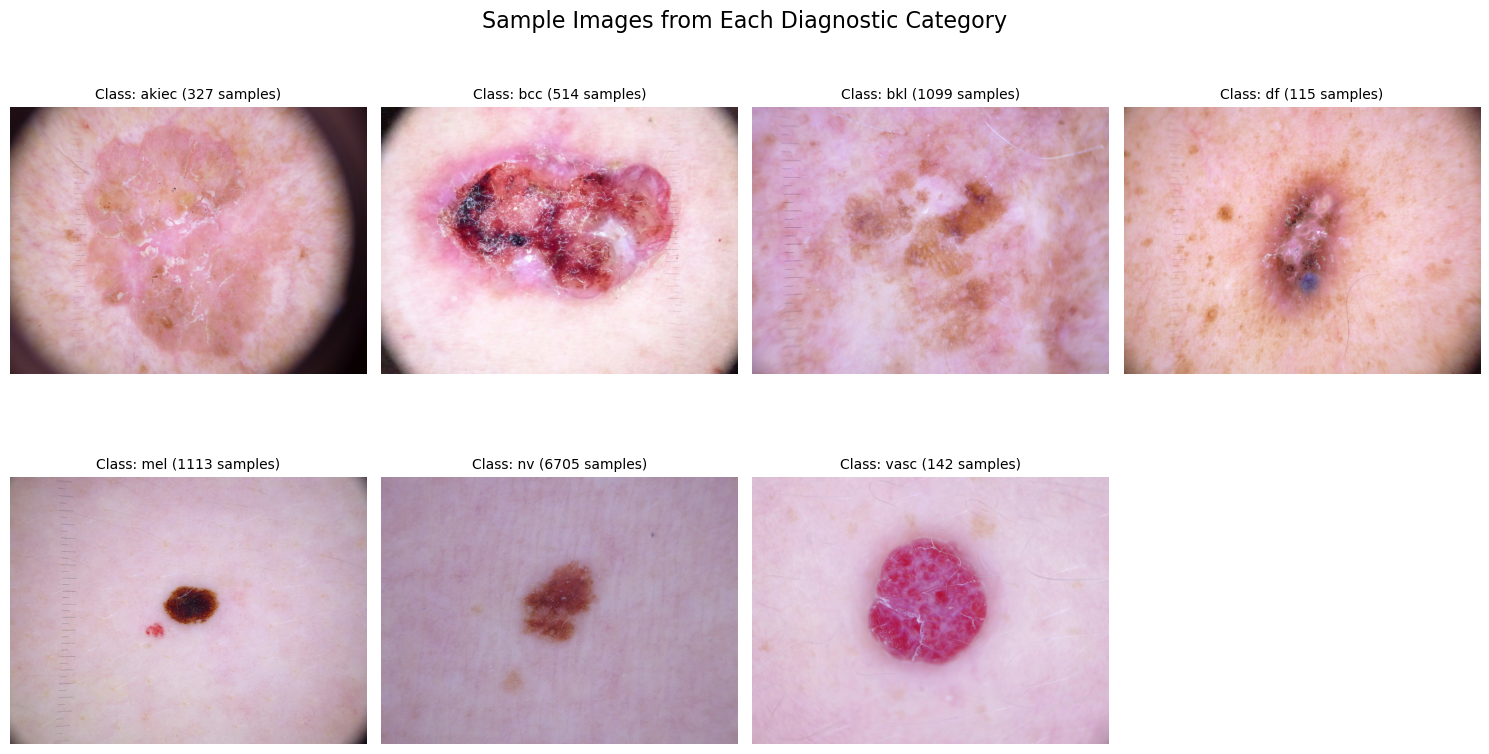

In [6]:
## Visualize Sample Images

# Get one sample image for each diagnostic category
sample_images = df.groupby('dx').first()

plt.figure(figsize=(15, 8))

for i, (dx, row) in enumerate(sample_images.iterrows()):
    image_id = row['image_id']
    img_path = os.path.join(IMAGE_FOLDER, image_id + '.jpg')
    
    try:
        img = Image.open(img_path)
    except FileNotFoundError:
        print(f"Image file not found for {image_id}")
        continue
        
    plt.subplot(2, 4, i + 1) # Adjust layout based on number of classes (7)
    plt.imshow(img)
    plt.title(f"Class: {dx} ({len(df[df['dx'] == dx])} samples)", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Each Diagnostic Category', fontsize=16, y=1.02)
plt.show()

In [ ]:
'''
4. Analyze Image Dimensions
Check if all images have a consistent size.
'''


Common Image Dimensions (Width x Height):
600x450    500
Name: count, dtype: int64


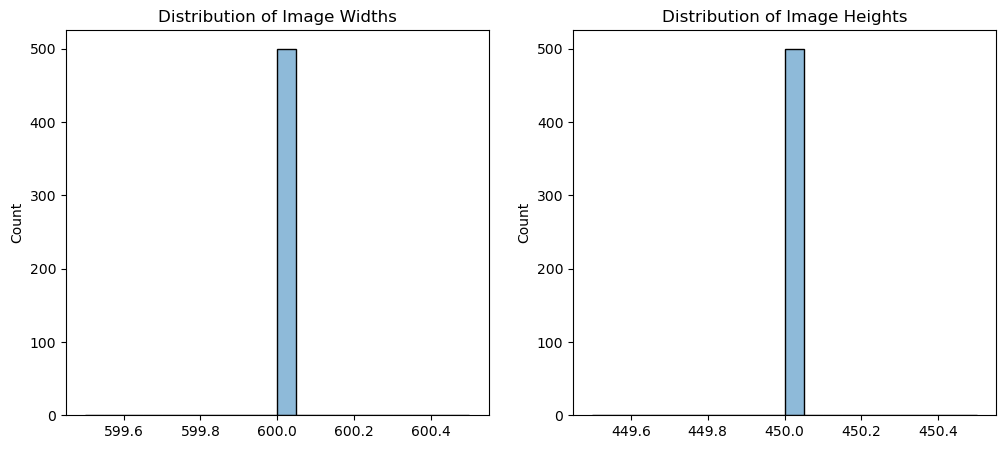

In [7]:
## Check Image Dimensions

# Function to get dimensions safely
def get_dims(image_id):
    path = os.path.join(IMAGE_FOLDER, image_id + '.jpg')
    try:
        with Image.open(path) as img:
            return img.size # (width, height)
    except:
        return (None, None)

# Apply the function to a sample of the data (or the whole data if fast enough)
# For the full HAM10000, checking all images can take a few minutes.
# For efficiency, let's sample or use the first few hundred.
df_sample = df.sample(n=500, random_state=42) # Sample 500 images

dims = np.array([get_dims(id) for id in df_sample['image_id']])
dims = dims[dims[:, 0] != None] # Filter out failures

if len(dims) > 0:
    widths = dims[:, 0].astype(int)
    heights = dims[:, 1].astype(int)

    print(f"\nCommon Image Dimensions (Width x Height):")
    print(pd.Series([f"{w}x{h}" for w, h in zip(widths, heights)]).value_counts().head())

    # Plot distribution of widths and heights
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(widths, kde=True, bins=20)
    plt.title('Distribution of Image Widths')
    
    plt.subplot(1, 2, 2)
    sns.histplot(heights, kde=True, bins=20)
    plt.title('Distribution of Image Heights')
    plt.show()

In [ ]:
'''
Key Takeaway from EDA:
The most important observation is the severe class imbalance. 
This confirms that you must use strategies like:
1) Stratified Splitting (which we did in the setup phase).
2) Weighted Loss Functions during training.
3) Over-sampling the minority classes or Under-sampling the majority class.
4) Using metrics like F1-Score, AUC, and the Confusion Matrix instead of simple accuracy.
'''

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# --- Configuration (Ensure paths match your setup) ---
DATA_DIR = 'data' 
METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv') 

# Load the full metadata
full_df = pd.read_csv(METADATA_FILE)

# --- Perform Stratified Split ---
# Stratified means the class proportions ('dx') are maintained in both the 
# training and validation sets. This is crucial for imbalanced data.
train_df, val_df = train_test_split(
    full_df, 
    test_size=0.2, # 80% for training, 20% for validation
    random_state=42, 
    stratify=full_df['dx'] 
)

# --- Save the Split DataFrames ---
TRAIN_METADATA_PATH = os.path.join(DATA_DIR, 'train_metadata.csv')
VAL_METADATA_PATH = os.path.join(DATA_DIR, 'val_metadata.csv')

train_df.to_csv(TRAIN_METADATA_PATH, index=False)
val_df.to_csv(VAL_METADATA_PATH, index=False)

print(f"✅ Data split complete.")
print(f"   Training Samples: {len(train_df)} (Saved to: {TRAIN_METADATA_PATH})")
print(f"   Validation Samples: {len(val_df)} (Saved to: {VAL_METADATA_PATH})")

# Verify Stratification (Optional Check)
print("\nTraining Set Class Proportions:")
print(train_df['dx'].value_counts(normalize=True))
print("\nValidation Set Class Proportions:")
print(val_df['dx'].value_counts(normalize=True))

✅ Data split complete.
   Training Samples: 8012 (Saved to: data/train_metadata.csv)
   Validation Samples: 2003 (Saved to: data/val_metadata.csv)

Training Set Class Proportions:
dx
nv       0.669496
mel      0.111083
bkl      0.109710
bcc      0.051298
akiec    0.032701
vasc     0.014229
df       0.011483
Name: proportion, dtype: float64

Validation Set Class Proportions:
dx
nv       0.669496
mel      0.111333
bkl      0.109835
bcc      0.051423
akiec    0.032451
vasc     0.013979
df       0.011483
Name: proportion, dtype: float64
